### Evaluation of PSFRMS comparing results with iAntConfig

In [1]:
%matplotlib inline
from __future__ import print_function, division, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FormatStrFormatter
from pyuvwsim import evaluate_baseline_uvw_ha_dec
from math import radians, degrees, pi, ceil, sin, asin, log10
import oskar

In [70]:
# Settings
# http://www.vla.nrao.edu/genpub/overview/
lat = radians(34 + 4.0 / 60.0 + 43.497 / 3600.0)  
lon = -radians(107 + 37 / 60 + 3.819 / 3600.0)
dec = -radians(30) + (lat - radians(30))
ha_min = -0.0
ha_max = +0.0
dump_time = 10 # min
duration = ha_max - ha_min
num_times = 1 if duration == 0.0 \
    else ((duration) * 60) // dump_time  # 1 sample every 10 min
freq_hz = 1000.0e6
oversampling = 2.4  # uv grid oversampling
dish_d = 25.0  # m
res_n = 20  # Number of radial points
res_bmin = None  # minimum radius bin value in m, or None
res_bmax = None  # maximum radius bin value in m, or None

In [71]:
# Load CASA VLA-C XYZ (ECEF) coordinates.
coords = np.loadtxt('../models/vla.c.cfg')
x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]

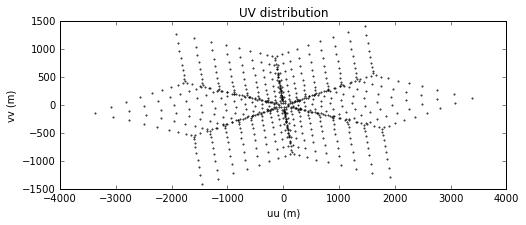

In [72]:
# Generate UV coordinates
uu, vv, ww = np.array([]), np.array([]), np.array([])
ha1_rad = (ha_min / 24) * (2 * pi)
ha2_rad = (ha_max / 24) * (2 * pi)
for i, ha in enumerate(np.linspace(ha1_rad, ha2_rad, num_times)):
    uu_, vv_, ww_ = evaluate_baseline_uvw_ha_dec(x, y, z, ha - lon, dec)
    uu, vv, ww = np.append(uu, uu_), np.append(vv, vv_), np.append(ww, ww_)
        
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, aspect='equal')
ax.plot(uu, vv, '.', color='k', ms=3.0, alpha=0.7)
ax.plot(-uu, -vv, '.', color='k', ms=3.0, alpha=0.7)
ax.set_xlabel('uu (m)')
ax.set_ylabel('vv (m)')
ax.set_title('UV distribution')
plt.show()

In [73]:
# Grid the uv data
r2d = (uu**2 + vv**2)**0.5
b_max = r2d.max() * 2.01
grid_size = int(ceil(oversampling * (b_max / dish_d)))
if grid_size % 2 == 1:
    grid_size += 1
cell = b_max / grid_size
wavelength = 299792458.0 / freq_hz
cell_lm = 1.0 / (grid_size * (cell / wavelength))
lm_max = (grid_size * sin(cell_lm)) / 2.0
fov = degrees(asin(lm_max)) * 2.0

# FIXME(BM) interface for cell size to avoid having to set via fov
imager = oskar.imager.Imager('Single')
imager.set_size(grid_size)
imager.set_grid_kernel('Pillbox', 1, 1)
imager.set_fov(fov)
uv_grid = np.zeros((grid_size, grid_size), dtype='c8')
norm = imager.update_plane(uu / wavelength, vv / wavelength,
                           np.zeros_like(uu), np.ones_like(uu, dtype='c8'), 
                           np.ones_like(uu), uv_grid, 0.0)
norm += imager.update_plane(-uu / wavelength, -vv / wavelength,
                            np.zeros_like(uu), 
                            np.ones_like(uu, dtype='c8'), 
                            np.ones_like(uu), uv_grid, 0.0)
assert(int(norm) == uu.shape[0] * 2)

In [74]:
# Evaluate global psfrms
psfrms = np.sqrt(np.sum(uv_grid.real**2)) / (uu.shape[0] * 2.0)
print('Global PSFRMS = %.7f' % psfrms)

Global PSFRMS = 0.0385932


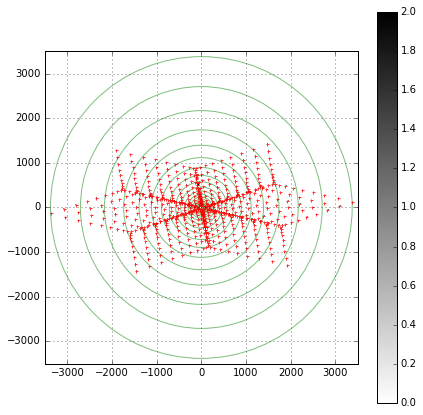

In [75]:
# Evaluate radial psfrms

# Get grid pixel coordinates and radius of each pixel
# FIXME(BM) make this a function call on the oskar imager
centre = grid_size // 2
x_ = np.arange(-centre, centre) * cell
gx, gy = np.meshgrid(-x_, x_)
gr = (gx**2 + gy**2)**0.5

# Work out radial bin edges
b0 = r2d.min() if not res_bmin else res_bmin
b1 = r2d.max() if not res_bmax else res_bmax
r_bins = np.logspace(log10(b0), log10(b1), res_n + 1)

psfrms_r = np.zeros(res_n)
for i in range(res_n):
    pixels = uv_grid[np.where(gr <= r_bins[i + 1])]
    uv_idx = np.where(r2d <= r_bins[i + 1])[0]                    
    uv_count = uv_idx.shape[0] * 2
    psfrms_r[i] = 1.0 if uv_count == 0 else \
        np.sqrt(np.sum(pixels.real**2)) / uv_count
        
# Plotting
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111)
for i in range(res_n + 1):
    c = plt.Circle((0.0, 0.0), r_bins[i], fill=False, color='g',
                   linestyle='-', linewidth=1, alpha=0.5)
    ax.add_artist(c)     
extent = [centre + 0.5, -centre + 0.5, -centre - 0.5, centre - 0.5]
extent = np.array(extent) * cell
im = ax.imshow(uv_grid.real, interpolation='nearest', cmap='gray_r', 
               origin='lower', extent=extent)
ax.figure.colorbar(im, ax=ax)
ax.plot(uu, vv, '+', ms=3.0, color='r', alpha=0.8, mew=1.0)
ax.plot(-uu, -vv, '+', ms=3.0, color='r', alpha=0.8, mew=1.0)
xy_lim = 3500.0 
ax.set_xlim(-xy_lim, xy_lim)
ax.set_ylim(-xy_lim, xy_lim)
ax.grid()
plt.show()

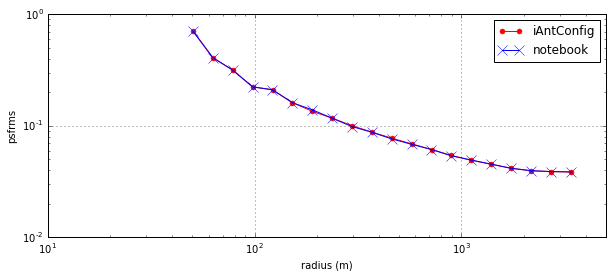

In [76]:
# Compare with results from iAntConfig 
# (http://public.ska.ac.za/software/iantconfig)
data = np.loadtxt('/Users/bmort/Desktop/vla_c_snapshot.20x2.txt', skiprows=1)
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)
ax.plot(data[:, 0], data[:, 1], 'r.-', ms=10, label='iAntConfig')
ax.plot(r_bins[1:], psfrms_r, 'bx-', ms=10, label='notebook')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(10, 5000)
ax.grid(True)
ax.set_xlabel('radius (m)')
ax.set_ylabel('psfrms')
ax.legend()
plt.show()